In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import pickle
import matplotlib.image as mpimg
from moviepy.editor import VideoFileClip
from collections import deque

%matplotlib inline

In [2]:
debug = False
video_output = './output_videos/project_video_out.mp4'
input_path = './test_videos/project_video.mp4'
image_name = 'test1'

In [3]:
def camera_calibration():
    # Prepare object points 0,0,0 ... 8,5,0
    obj_pts = np.zeros((6*9,3), np.float32)
    obj_pts[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

    # Stores all object points & img points from all images
    objpoints = []
    imgpoints = []

    # Get directory for all calibration images
    images = glob.glob('camera_cal/*.jpg')
    img = None
    for indx, fname in enumerate(images):
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

        if ret == True:
            objpoints.append(obj_pts)
            imgpoints.append(corners)
    # Get image size
    img_size = (img.shape[1], img.shape[0])

    # Calibrate camera
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None,None)

    dst = cv2.undistort(img, mtx, dist, None, mtx)
    # Save camera calibration for later use
    dist_pickle = {}
    dist_pickle['mtx'] = mtx
    dist_pickle['dist'] = dist
    pickle.dump(dist_pickle, open('camera_cal_pickle.p', 'wb'))


camera_calibration()

In [4]:
dist_pickle = "./camera_cal_pickle.p"
with open(dist_pickle, mode="rb") as f:
    CalData = pickle.load(f)
mtx, dist = CalData["mtx"], CalData["dist"]

In [5]:
# Define a class to receive the characteristics of each line detection
class Line:
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False

        # x and y values in last frame
        self.x = None
        self.y = None

        # x intercepts for average smoothing
        self.bottom_x = deque(maxlen=frame_num)
        self.top_x = deque(maxlen=frame_num)

        # Record last x intercept
        self.current_bottom_x = None
        self.current_top_x = None

        # Record radius of curvature
        self.radius = None

        # Polynomial coefficients: x = A*y**2 + B*y + C
        self.A = deque(maxlen=frame_num)
        self.B = deque(maxlen=frame_num)
        self.C = deque(maxlen=frame_num)
        self.fit = None
        self.fitx = None
        self.fity = None



    def quick_sliding_window(self, nonzerox, nonzeroy, image):
        """
        Assuming in last frame, lane has been detected. Based on last x/y coordinates, quick search current lane.
        """
        x_inds = []
        y_inds = []
        out_img = np.dstack((image, image, image)) * 255
        if self.detected:
            win_bottom = 720
            win_top = 630
            while win_top >= 0:
                yval = np.mean([win_top, win_bottom])
                xval = (np.median(self.A)) * yval ** 2 + (np.median(self.B)) * yval + (np.median(self.C))
                x_idx = np.where((((xval - 50) < nonzerox)
                                  & (nonzerox < (xval + 50))
                                  & ((nonzeroy > win_top) & (nonzeroy < win_bottom))))
                x_window, y_window = nonzerox[x_idx], nonzeroy[x_idx]
                cv2.rectangle(out_img, (int(xval - 50), win_top), (int(xval + 50), win_bottom),
                              (0, 255, 0), 2)
                if np.sum(x_window) != 0:
                    np.append(x_inds, x_window)
                    np.append(y_inds, y_window)
                win_top -= 90
                win_bottom -= 90
        if np.sum(x_inds) == 0:
            self.detected = False  # If no lane pixels were detected then perform blind search
        return x_inds, y_inds, out_img

    def blind_sliding_window(self, nonzerox, nonzeroy, image):
        """
        Sliding window search method, start from blank.
        """
        x_inds = []
        y_inds = []
        out_img = np.dstack((image, image, image)) * 255
        if self.detected is False:
            win_bottom = 720
            win_top = 630
            histogram_complete = np.sum(image[200:, :], axis=0)
            while win_top >= 0:
                histogram = np.sum(image[win_top:win_bottom, :], axis=0)
                if self == right:
                    base = (np.argmax(histogram[640:-60]) + 640) \
                    if np.argmax(histogram[640:-60]) > 0\
                    else (np.argmax(histogram_complete[640:]) + 640)
                else:
                    base = np.argmax(histogram[:640]) \
                        if np.argmax(histogram[:640]) > 0 \
                        else np.argmax(histogram_complete[:640])
                x_idx = np.where((((base - 50) < nonzerox) & (nonzerox < (base + 50))
                                  & ((nonzeroy > win_top) & (nonzeroy < win_bottom))))
                x_window, y_window = nonzerox[x_idx], nonzeroy[x_idx]
                cv2.rectangle(out_img, (int(base - 50), win_top), (int(base + 50), win_bottom),
                              (0, 255, 0), 2)
                if np.sum(x_window) != 0:
                    x_inds.extend(x_window)
                    y_inds.extend(y_window)
                win_top -= 90
                win_bottom -= 90
        if np.sum(x_inds) > 0:
            self.detected = False
        else:
            y_inds = self.y
            x_inds = self.x
        return x_inds, y_inds, out_img



In [6]:
img_shape = (720, 1280)
img_size = [1280, 720]  # width, height

src = np.float32([[490, 482], [810, 482],
                  [1250, 720], [0, 720]])
dst = np.float32([[0, 0], [1280, 0],
                  [1250, 720], [40, 720]])
ploty = np.linspace(0, img_shape[0] - 1, img_shape[0])

# latest frames number of good detection
frame_num = 15

left = Line()
right = Line()

(-0.5, 1279.5, 719.5, -0.5)

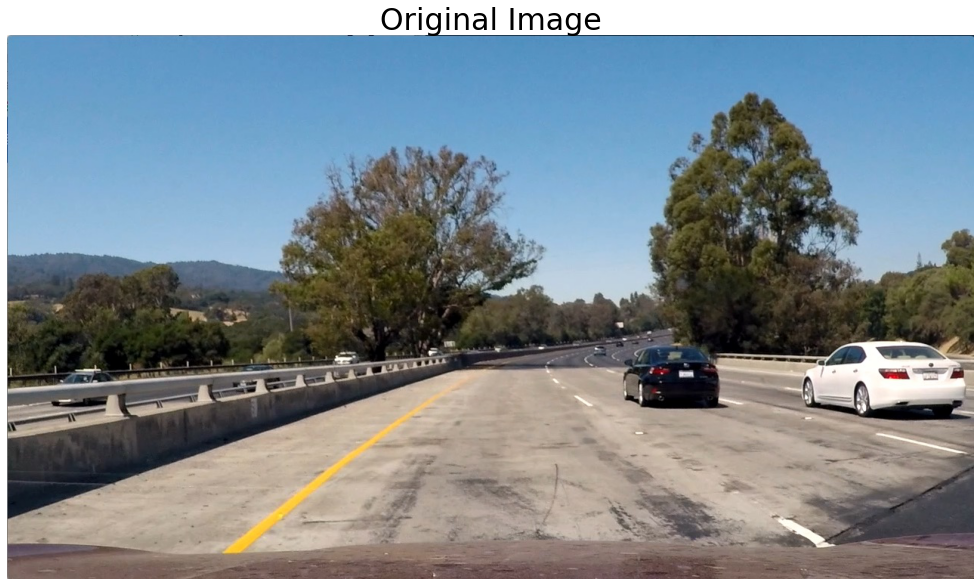

In [7]:
# Read Image
o_img = mpimg.imread(f'./test_images/{image_name}.jpg')

# Visualize Original Image
f, (ax1) = plt.subplots(1, 1, figsize=(20,10))
ax1.imshow(o_img)
ax1.set_title('Original Image', fontsize=30)
ax1.axis("off")

(-0.5, 1279.5, 719.5, -0.5)

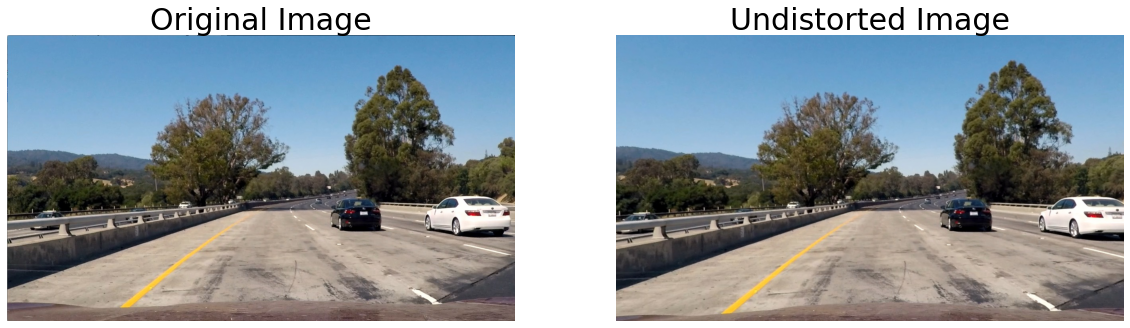

In [8]:
def undistort(img, mtx, dist):
    """
    Use cv2.undistort to undistort
    :param img: Assuming input img is RGB (imread by mpimg)
    :param mtx: camera calibration parameter
    :param dist: camera calibration parameter
    :return: Undistorted img
    """
    # transform to BGR to fit cv2.imread
    img_BGR = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    dst_img = cv2.undistort(img_BGR, mtx, dist, None, mtx)

    return cv2.cvtColor(dst_img, cv2.COLOR_BGR2RGB)
undist_img = undistort(o_img, mtx, dist)
# Visualize Undistorted Image
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(o_img)
ax1.set_title('Original Image', fontsize=30)
ax1.axis("off")
ax2.imshow(undist_img)
ax2.set_title('Undistorted Image', fontsize=30)
ax2.axis("off")

(-0.5, 1279.5, 719.5, -0.5)

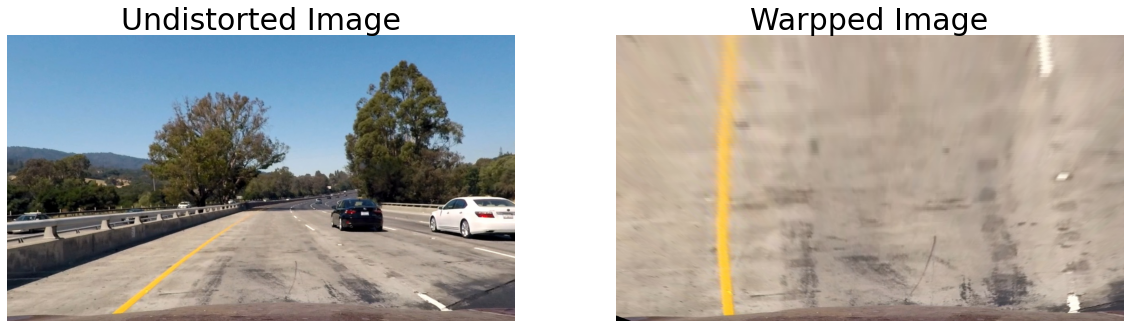

In [9]:
def warp(img):
    """
    Perspective Transformation
    :param img:
    :return: warped image
    """

    # Compute and apply perspective transform
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, (1280, 720), flags=cv2.INTER_NEAREST)  # keep same size as input image

    return warped

warped = warp(undist_img)

# Visualize Warp Image
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(undist_img)
ax1.set_title('Undistorted Image', fontsize=30)
ax1.axis("off")
ax2.imshow(warped)
ax2.set_title('Warpped Image', fontsize=30)
ax2.axis("off")

(-0.5, 1279.5, 719.5, -0.5)

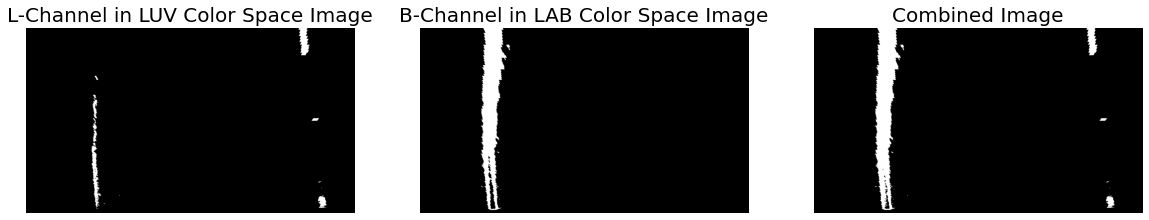

In [10]:
def luv_lab_filter(img, l_thresh=(195, 255), b_thresh=(140, 200)):
    l = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)[:, :, 0]
    l_bin = np.zeros_like(l)
    l_bin[(l >= l_thresh[0]) & (l <= l_thresh[1])] = 1

    b = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)[:, :, 2]
    b_bin = np.zeros_like(b)
    b_bin[(b >= b_thresh[0]) & (b <= b_thresh[1])] = 1

    combine = np.zeros_like(l)
    combine[(l_bin == 1) | (b_bin == 1)] = 1

    return l_bin, b_bin, combine

l_bin, b_bin, warped_binary = luv_lab_filter(warped, l_thresh=(215, 255), b_thresh=(145, 200))

# Visualize Filtered Image
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,10))
ax1.imshow(l_bin, cmap='gray')
ax1.set_title('L-Channel in LUV Color Space Image', fontsize=20)
ax1.axis("off")
ax2.imshow(b_bin, cmap='gray')
ax2.set_title('B-Channel in LAB Color Space Image', fontsize=20)
ax2.axis("off")
ax3.imshow(warped_binary, cmap='gray')
ax3.set_title('Combined Image', fontsize=20)
ax3.axis("off")

(-0.5, 1279.5, 719.5, -0.5)

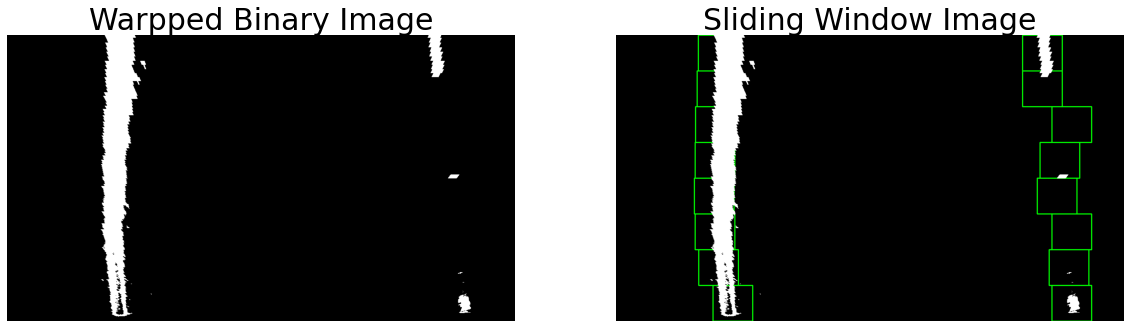

In [12]:
nonzerox, nonzeroy = np.nonzero(np.transpose(warped_binary))

if left.detected is True:
    leftx, lefty, out_img_left = left.quick_sliding_window(nonzerox, nonzeroy, warped_binary)
if right.detected is True:
    rightx, righty, out_img_right = right.quick_sliding_window(nonzerox, nonzeroy, warped_binary)
if left.detected is False:
    leftx, lefty, out_img_left = left.blind_sliding_window(nonzerox, nonzeroy, warped_binary)
if right.detected is False:
    rightx, righty, out_img_right = right.blind_sliding_window(nonzerox, nonzeroy, warped_binary)

out_combine = cv2.addWeighted(out_img_left, 1, out_img_right, 1, 0)

# Visualize Filtered Image
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(warped_binary, cmap='gray')
ax1.set_title('Warpped Binary Image', fontsize=30)
ax1.axis("off")
ax2.imshow(out_combine)
ax2.set_title('Sliding Window Image', fontsize=30)
ax2.axis("off")